In [9]:
import numpy as np
import transformers
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

from transformers import AutoModelForCausalLM, GPT2Tokenizer

In [10]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = AutoModelForCausalLM.from_pretrained('gpt2')

#encoding
text = 'The goal of a correlation analysis is to compute a correlation coefficient. This coefficient is indicated using r, and is a number that encodes the normalized strength of the linear relationship between two variables. The normalization imposes boundaries of -1 to +1. Negative, zero, and positive correlation coefficients have distinct interpretations.'
tokens = tokenizer.encode(text, return_tensors = 'pt')
# print("tokens: ", tokens)

#forward
with torch.no_grad():
    outputs = model(tokens, output_hidden_states = True)

print("hidden states: ", len(outputs.hidden_states))
print(outputs.logits.shape)

hidden states:  13
torch.Size([1, 62, 50257])


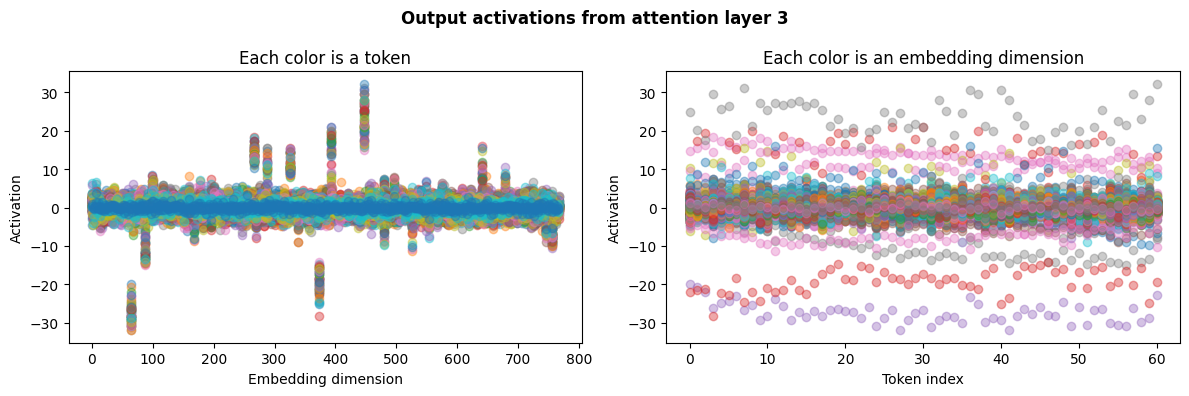

In [3]:
#scatter plot
layerToPlot = 3
y = outputs.hidden_states[layerToPlot][0,1:,:].detach()
_, axs = plt.subplots(1, 2, figsize=(12, 4))

# plot by embedding
axs[0].plot(y.T,'o',alpha=.4)
axs[0].set(xlabel='Embedding dimension',ylabel='Activation',title='Each color is a token')

# plot by token
axs[1].plot(y,'o',alpha=.4)
axs[1].set(xlabel='Token index',ylabel='Activation',title='Each color is an embedding dimension')

plt.suptitle(f'Output activations from attention layer {layerToPlot}',fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
# Layer Covariance
points = (tokens.shape[1] - 1) * model.config.n_embd  # Use tokens.shape[1] to get sequence length
alldata = np.zeros((len(outputs.hidden_states), points))

for layer in range(len(outputs.hidden_states)):
    vector = outputs.hidden_states[layer][0, 1:, :].flatten().detach().numpy()  # Add .detach()
    alldata[layer, :] = vector


Shape of alldata: (13, 46848)
Number of layers: 13
Points per layer: 46848


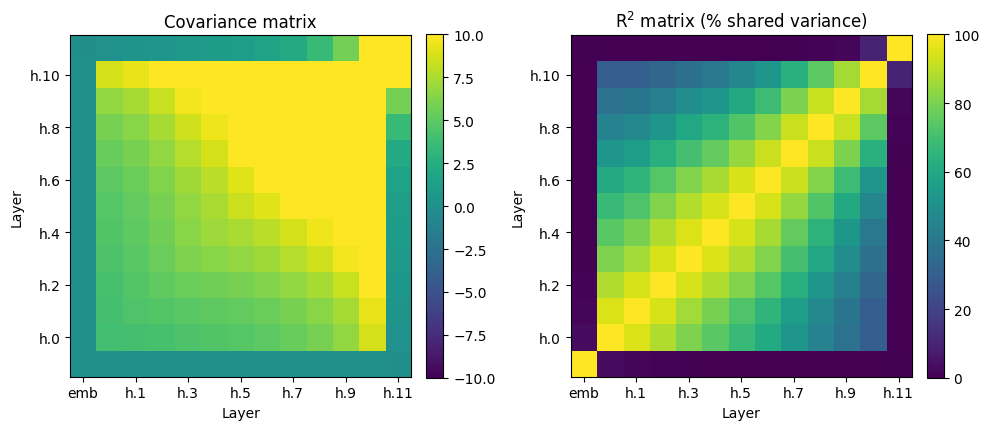

In [13]:
# create covariance 
covmat = np.cov(alldata)

cormat = np.corrcoef(alldata) ** 2

# layer names
layerlabels = ['emb' if i==0 else f'h.{i-1}' for i in range(13)]

# set the figure
_,axs = plt.subplots(1,2,figsize=(10,5))

h = axs[0].imshow(covmat,vmin=-10,vmax=10,origin='lower')
axs[0].set(xlabel='Layer',ylabel='Layer',title='Covariance matrix',
           xticks=range(0,len(layerlabels),2),xticklabels=layerlabels[::2],
           yticks=range(1,len(layerlabels),2),yticklabels=layerlabels[1::2])
plt.colorbar(h,ax=axs[0],pad=.04,fraction=.046)

h = axs[1].imshow(100*cormat,vmin=0,vmax=100,origin='lower')
axs[1].set(xlabel='Layer',ylabel='Layer',title=r'R$^2$ matrix (% shared variance)',
           xticks=range(0,len(layerlabels),2),xticklabels=layerlabels[::2],
           yticks=range(1,len(layerlabels),2),yticklabels=layerlabels[1::2])
plt.colorbar(h,ax=axs[1],pad=.04,fraction=.046)

plt.tight_layout()
plt.show()